In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from functools import partial
import qiskit as qk
from qiskit.providers.ibmq import least_busy
from qiskit.quantum_info import state_fidelity
from qiskit.tools.visualization import circuit_drawer, plot_histogram

In [2]:
#qk.IBMQ.save_account('AUTHORIZATION TOKEN GOES HERE') #EXECUTE ONLY ONCE: The access token is stored in temp files inside 
ibmq_provider = qk.IBMQ.load_account()

C:\Users\jeany\anaconda3\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


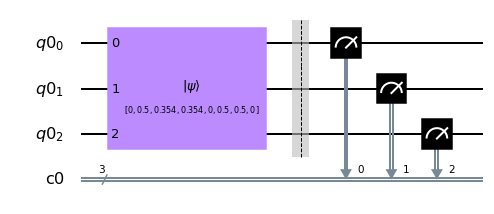

In [3]:
qr = qk.QuantumRegister(3)
cr = qk.ClassicalRegister(3)
qc = qk.QuantumCircuit(qr, cr)

init_vector = [0, 1/2, 1/np.sqrt(8), 1/np.sqrt(8), 0, 1/2, 1/2, 0] #Has to be normalized


qc.initialize(init_vector, [qr[0], qr[1], qr[2]]) #Initialize system state with init_vector

qc.barrier()

qc.measure(range(3), range(3))

qc.draw('mpl')

Qiskit compiles all circuits to only CNOT and U3 (general rotations) gates. The above circuit is compiled into the following:

![title](circuit_diagrams/circuit-kfk2fxzz.svg)

This is the actual compiled OPENQASM code the machine executes:
~~~
OPENQASM 2.0;
include "qelib1.inc";

qreg q[5];

creg c7[3];


u3(1.9634954084936207, 0, 0) q[0];
u2(0, 0) q[1];
u2(0, 2.220446049250313e-16) q[2];
cx q[2], q[1];
u3(-1.1102230246251565e-16, 0, 0) q[1];
cx q[2], q[1];
cx q[1], q[0];
u3(1.1780972450961724, 0, 0) q[0];
cx q[1], q[2];
cx q[2], q[1];
cx q[1], q[2];
cx q[1], q[0];
cx q[0], q[1];
cx q[1], q[0];
cx q[0], q[1];
u3(-0.39269908169872414, 0, 0) q[1];
cx q[2], q[1];
u3(0.39269908169872414, 0, 0) q[1];
cx q[0], q[1];
barrier q[0], q[3], q[2], q[4], q[1];
measure q[1] -> c7[0];
measure q[2] -> c7[1];
measure q[0] -> c7[2];
~~~

## BARRIERS ARE IMPORTANT!!
They instruct the compiler to not merge different code sections we want explicitly separated.

## Simulated output (local):

{'001': 2092, '010': 995, '011': 1007, '101': 2036, '110': 2062}


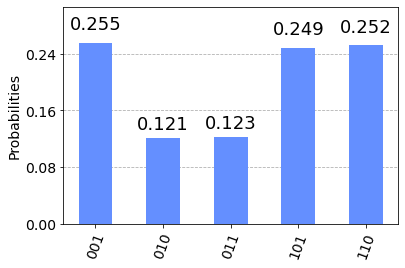

In [46]:
job = qk.execute(qc, backend=qk.Aer.get_backend('qasm_simulator'), shots=8192)
res = job.result()

counts = res.get_counts(qc)
print(counts)

fig = plt.figure()
plt.rcParams.update({'font.size': 18})
ax = fig.add_subplot(111)
plot_histogram(counts, ax=ax)

## Real QC execution (ibmq_melbourne, 15 qubits, QV=8):

{'000': 458, '001': 2411, '010': 1366, '011': 995, '100': 249, '101': 1295, '110': 1325, '111': 93}


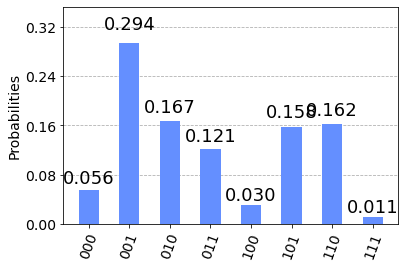

In [56]:
#ibmq_backend = least_busy(ibmq_provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and not b.configuration().simulator and b.status().operational==True))
ibmq_backend = ibmq_provider.backends('ibmq_16_melbourne')[0]

job = qk.execute(qc, backend=ibmq_backend, shots=8192)
res = job.result()

counts = res.get_counts(qc)
print(counts)

fig = plt.figure()
plt.rcParams.update({'font.size': 18})
ax = fig.add_subplot(111)
plot_histogram(counts, ax=ax)

## Real QC execution (ibmq_valencia, 5 qubits, QV=16):

{'000': 1204, '001': 1711, '010': 979, '011': 658, '100': 846, '101': 1156, '110': 1466, '111': 172}


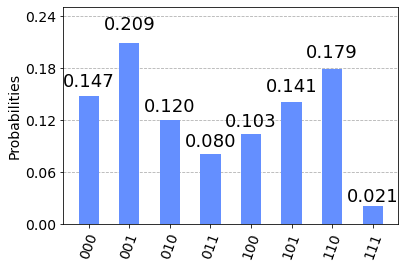

In [57]:
#ibmq_backend = least_busy(ibmq_provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and not b.configuration().simulator and b.status().operational==True))
ibmq_backend = ibmq_provider.backends('ibmq_valencia')[0]

job = qk.execute(qc, backend=ibmq_backend, shots=8192)
res = job.result()

counts = res.get_counts(qc)
print(counts)

fig = plt.figure()
plt.rcParams.update({'font.size': 18})
ax = fig.add_subplot(111)
plot_histogram(counts, ax=ax)

## Real QC execution (ibmq_santiago, 5 qubits, QV=32):

In theory, this following execution should have the lowest noise, and should better resemble the simulated output, given that the 'ibmq_santiago' processor has the highest QV (quantum volume).

As stated in Qiskit docs:

>Quantum Volume (QV) is a single-number metric that can be measured using a concrete protocol on near-term quantum computers of modest size. The QV method quantifies the largest random circuit of equal width and depth that the computer successfully implements. Quantum computing systems with high-fidelity operations, high connectivity, large calibrated gate sets, and circuit rewriting toolchains are expected to have higher quantum volumes.
> (https://qiskit.org/textbook/ch-quantum-hardware/measuring-quantum-volume.html)

{'000': 275, '001': 1788, '010': 652, '011': 1391, '100': 269, '101': 1752, '110': 1867, '111': 198}


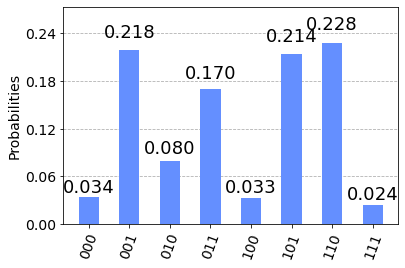

In [51]:
ibmq_backend = ibmq_provider.backends('ibmq_santiago')[0]

job = qk.execute(qc, backend=ibmq_backend, shots=8192)
res = job.result()

counts = res.get_counts(qc)
print(counts)

fig = plt.figure()
plt.rcParams.update({'font.size': 18})
ax = fig.add_subplot(111)
plot_histogram(counts, ax=ax)